# Analysing residual bath RWA

In [114]:
from qutip import basis, qeye, tensor, destroy, thermal_dm, mesolve, steadystate, Options
import matplotlib.pyplot as plt
import numpy as np
from utils import *
import phonons as RC
from style import *
import optical as EM
import time

G= basis(2,0)
E = basis(2,1)

sigma = G*E.dag()

I_sys = qeye(2)
initial_sys = G*G.dag()#0.5*(E+G)*(G.dag()+E.dag())
T_EM = 0.
reload(RC)
reload(EM)


<module 'optical' from 'optical.pyc'>

In [119]:
reload(RC)
from numpy import sqrt
def reorg(Gamma, w0, alpha):
    print Gamma, w0, alpha
    sub_factor = sqrt(Gamma**2 - 4*(w0**2))
    denom  = sqrt(Gamma**2 - 2*(w0**2)-Gamma*sub_factor)+sqrt(Gamma**2 - 2*(w0**2)+Gamma*sub_factor)
    denom *= (pi*alpha*Gamma)/sqrt(2)
    return denom

def IBM_dynamics(alpha=0.01, w0=0.01, Gamma=0.01, N=3, RWA_comp=False):
    initial_sys = 0.5*(E+G)*(G.dag()+E.dag())
    epsilon = 1000.
    
    T_ph = 77.
    w0=w0*epsilon
    alpha_ph = epsilon*alpha
    Gamma = epsilon*Gamma #(w0**2)/100.
    print  reorg(Gamma, w0, alpha_ph)
    if Gamma >= 2*w0:
        phonon_shift = reorg(Gamma, w0, alpha_ph)
    else:
        phonon_shift = 0.
    #Gamma_EM =  100*5.309e-3
    
    
    #kappa= np.sqrt(np.pi * alpha_ph * w0 / 2.)
    #shift = ((kappa**2)/w0)
    #w_laser #+= shift
    H_sub = epsilon*sigma.dag()*sigma
    print H_sub, " TLS "
    tf =  0.5 #0.025

    timelist = np.linspace(0, tf, 1000)
    
    n_RC = EM.Occupation(w0, T_ph)

    I = qeye(N)
    print "T_ph={}".format(T_ph)
    #print "Exact solution took {} seconds.".format(time.time()-ti)
    expects = [tensor(G*G.dag(), I), 0.5*tensor(E*G.dag()+G*E.dag(), I), 0.5*(1j*tensor(E*G.dag()-G*E.dag(), I)),
               tensor(E*E.dag(), I), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]
    
    rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
    # b is RC collapse operator
    #H, A_EM, b, wRC, kappa, gamma = RC.mapped_operators_and_constants(H_sub, sigma, T_ph, Gamma, 
    #                                                                  w0, alpha_ph, N)
    L_full, H, A_EM, b, Z, wRC, kappa, gamma = RC.RC_mapping_general(H_sub, sigma, T_ph, 
                                                                  Gamma, w0, alpha_ph, N, silent=False)
    # L_RC, H, A_em, A_ph, Z, wRC, kappa, gamma
    RWA_collapse = b - (kappa/wRC)*A_EM.dag()*A_EM
    J = J_RC
    if RWA_comp:
        S_plus, S_minus, S_0 = EM.RWA_system_ops(H, b+b.dag())
        L_full = EM.L_nonsecular(H, S_minus, gamma, gamma, T_ph, J, silent=True) # numerical RWA
        
    
    
    L_RWA = EM.L_nonsecular(H, RWA_collapse, gamma, gamma, T_ph, J, silent=True)
    
    #print L_full, L_RWA
    #print steadystate(H, [L_full]).ptrace(0), steadystate(H, [L_RWA]).ptrace(0)
    #mesolve(H, rho0, tlist, c_ops=[], e_ops=[], args={}, options=None, progress_bar=None, _safe_mode=True)
    data = mesolve(H, rho_0, timelist, c_ops=[L_full], e_ops=expects, options = Options(nsteps=1500))
    data_RWA = mesolve(H, rho_0, timelist, c_ops=[L_RWA], e_ops=expects, options = Options(nsteps=1500))
    print("Dynamics complete")
    return timelist, data, data_RWA

def plot_IBM(alpha=0.01, w0=0.01, Gamma=0.01, N=6, RWA_comp=False):
    timelist, data, data_RWA = IBM_dynamics(alpha=alpha, w0=w0, 
                                            Gamma=Gamma, N=N, RWA_comp=RWA_comp)
    #plt.plot(timelist, data.expect[0], label='full')
    #plt.plot(timelist, data_RWA.expect[0], label='RWA', alpha=0.4)
    #plt.legend()
    #plt.figure()

    plt.plot(timelist, data.expect[2].real, label='full')
    plt.plot(timelist, data_RWA.expect[1].real, label='RWA', alpha=0.4)
    plt.legend()
    plt.figure()

    #plt.plot(timelist, data.expect[4].real, label='full')
    #plt.plot(timelist, data_RWA.expect[4].real, label='RWA', alpha=0.4)
    #plt.legend()
    #plt.figure()
    
    plt.plot(timelist, data.expect[5].real, label='full')
    plt.plot(timelist, data_RWA.expect[5].real, label='RWA', alpha=0.4)
    plt.legend()
    plt.show()

w0 = 0.01
Gamma= 2*w0
IBM_dynamics(alpha=0.01, w0=w0, Gamma=Gamma, N=6, RWA_comp=False)

20.0 10.0 10.0
12566.3706144
20.0 10.0 10.0
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=10.0 | RC-res. coupling=0.3183 | TLS-RC coupling=12.53 | Gamma_RC=20.00 | alpha_ph=10.00 | N=6 |
Dynamics complete


(array([ 0.        ,  0.0005005 ,  0.001001  ,  0.0015015 ,  0.002002  ,
         0.0025025 ,  0.003003  ,  0.0035035 ,  0.004004  ,  0.0045045 ,
         0.00500501,  0.00550551,  0.00600601,  0.00650651,  0.00700701,
         0.00750751,  0.00800801,  0.00850851,  0.00900901,  0.00950951,
         0.01001001,  0.01051051,  0.01101101,  0.01151151,  0.01201201,
         0.01251251,  0.01301301,  0.01351351,  0.01401401,  0.01451451,
         0.01501502,  0.01551552,  0.01601602,  0.01651652,  0.01701702,
         0.01751752,  0.01801802,  0.01851852,  0.01901902,  0.01951952,
         0.02002002,  0.02052052,  0.02102102,  0.02152152,  0.02202202,
         0.02252252,  0.02302302,  0.02352352,  0.02402402,  0.02452452,
         0.02502503,  0.02552553,  0.02602603,  0.02652653,  0.02702703,
         0.02752753,  0.02802803,  0.02852853,  0.02902903,  0.02952953,
         0.03003003,  0.03053053,  0.03103103,  0.03153153,  0.03203203,
         0.03253253,  0.03303303,  0.03353353,  0.0

# Comparing analytical RWA to numerical one

VARYING w0
25.0
0.0157079632679 !  nan
nan
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=50.0 | RC-res. coupling=0.0318 | TLS-RC coupling=28.02 | Gamma_RC=10.00 | alpha_ph=10.00 | N=10 |


/home/henry/anaconda2/envs/qutip/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


Dynamics complete


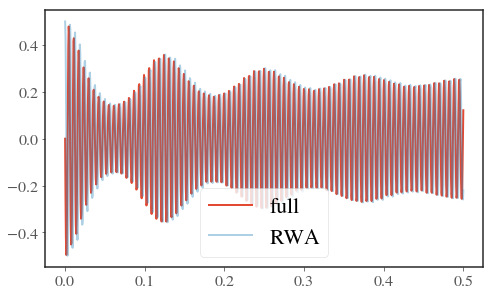

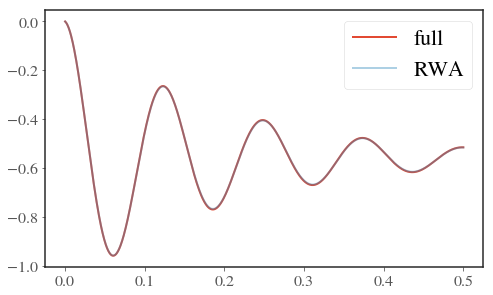

100.0
0.0157079632679 !  nan
nan
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=100.0 | RC-res. coupling=0.0159 | TLS-RC coupling=39.63 | Gamma_RC=10.00 | alpha_ph=10.00 | N=10 |
Dynamics complete


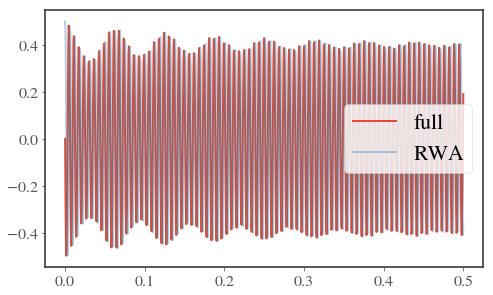

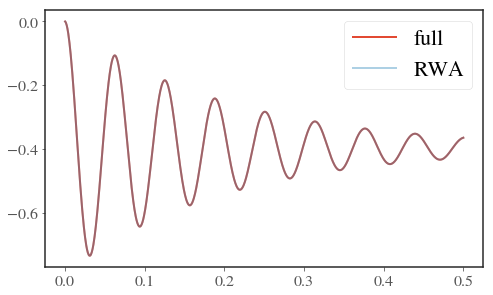

8100.0
0.0157079632679 !  nan
nan
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=900.0 | RC-res. coupling=0.0018 | TLS-RC coupling=118.90 | Gamma_RC=10.00 | alpha_ph=10.00 | N=6 |
Dynamics complete


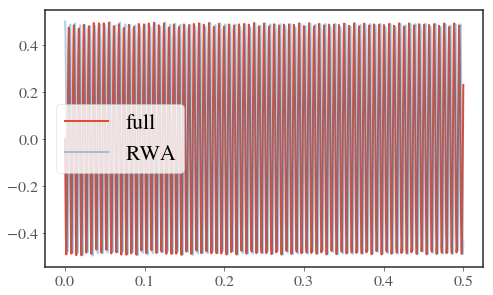

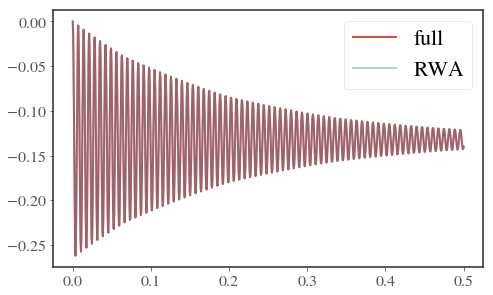

VARYING GAMMA
100.0
0.0157079632679 !  nan
nan
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=100.0 | RC-res. coupling=0.0159 | TLS-RC coupling=39.63 | Gamma_RC=10.00 | alpha_ph=10.00 | N=10 |
Dynamics complete


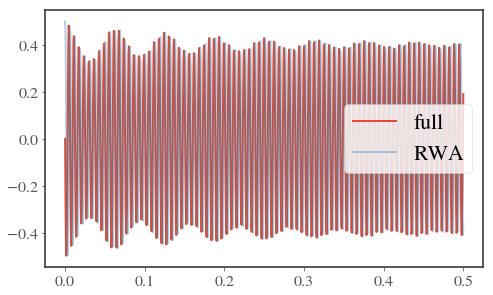

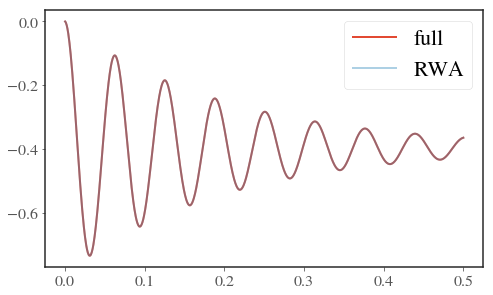

100.0
0.0157079632679 !  nan
nan
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=100.0 | RC-res. coupling=0.0796 | TLS-RC coupling=39.63 | Gamma_RC=50.00 | alpha_ph=10.00 | N=10 |
Dynamics complete


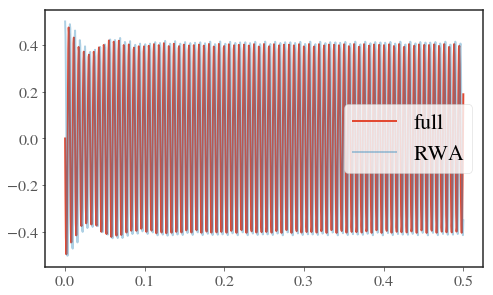

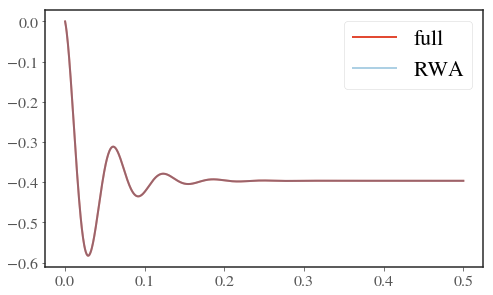

100.0
0.0157079632679 !  nan
nan
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=100.0 | RC-res. coupling=0.1592 | TLS-RC coupling=39.63 | Gamma_RC=100.00 | alpha_ph=10.00 | N=10 |
Dynamics complete


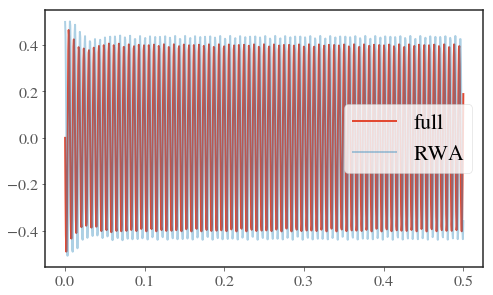

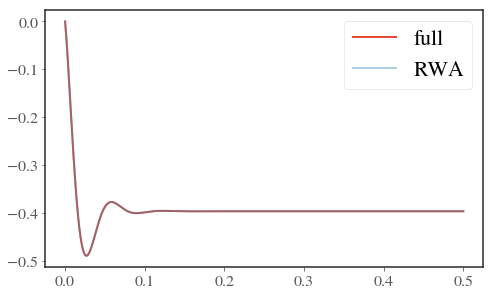

large w0 and large Gamma
8100.0
0.0157079632679 !  nan
nan
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=900.0 | RC-res. coupling=0.0177 | TLS-RC coupling=118.90 | Gamma_RC=100.00 | alpha_ph=10.00 | N=10 |
Dynamics complete


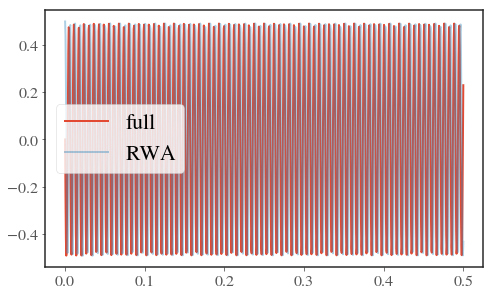

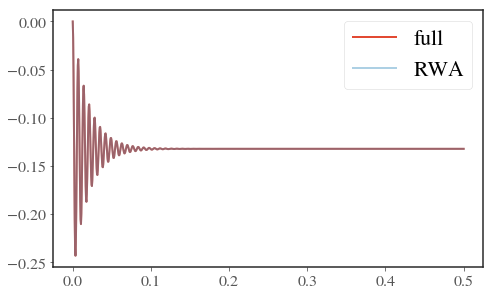

In [111]:
print "VARYING w0"
    
plot_IBM(alpha=0.01, w0=0.05, N=10, RWA_comp=True)
plot_IBM(alpha=0.01, w0=0.1, N=10, RWA_comp=True)
plot_IBM(alpha=0.01, w0=0.9, N=6, RWA_comp=True)

print "VARYING GAMMA"

plot_IBM(alpha=0.01, w0=0.1, Gamma =0.01, N=10, RWA_comp=True)
plot_IBM(alpha=0.01, w0=0.1, Gamma =0.05, N=10, RWA_comp=True)
plot_IBM(alpha=0.01, w0=0.1, Gamma =0.1, N=10, RWA_comp=True)

print "large w0 and large Gamma"
plot_IBM(alpha=0.01, w0=0.9, Gamma =0.1, N=10, RWA_comp=True)

## This code shows that the numerical RWA (moving to int. pic. wrt H_RC) matches analytical one (polaron)

# Comparing RWA to Full RC

VARYING w0
small w0
25.0
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=50.0 | RC-res. coupling=0.03 | TLS-RC coupling=28.02 | Gamma_RC=10.00 | alpha_ph=10.00 | N=10 |
Dynamics complete


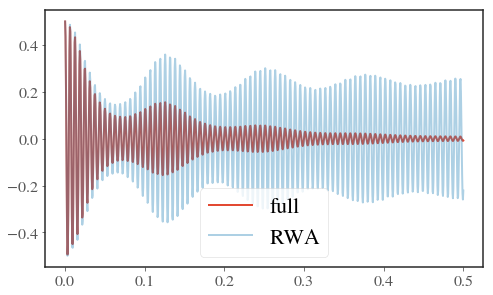

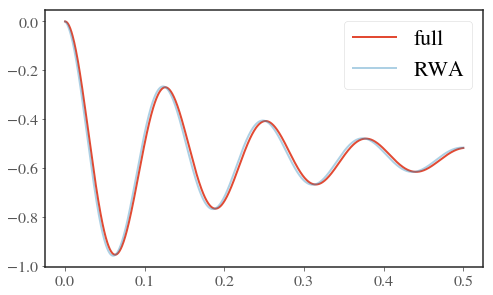

med w0
100.0
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=100.0 | RC-res. coupling=0.02 | TLS-RC coupling=39.63 | Gamma_RC=10.00 | alpha_ph=10.00 | N=10 |
Dynamics complete


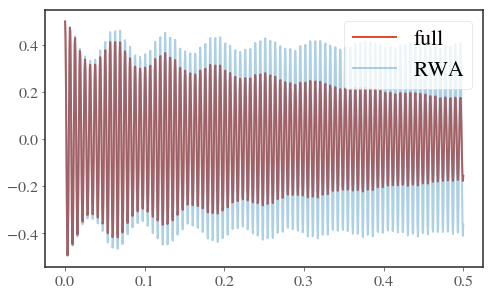

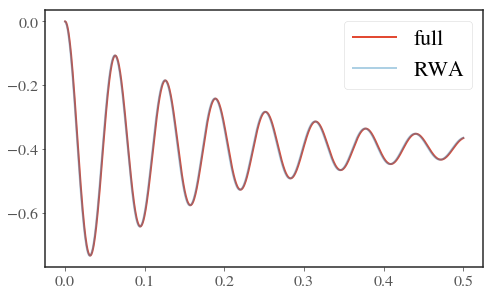

large w0
8100.0
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=900.0 | RC-res. coupling=0.00 | TLS-RC coupling=118.90 | Gamma_RC=10.00 | alpha_ph=10.00 | N=6 |
Dynamics complete


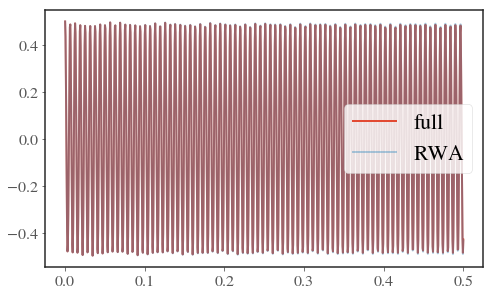

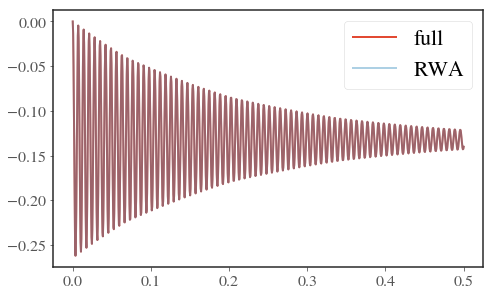

VARYING GAMMA
small Gamma
100.0
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=100.0 | RC-res. coupling=0.02 | TLS-RC coupling=39.63 | Gamma_RC=10.00 | alpha_ph=10.00 | N=10 |
Dynamics complete


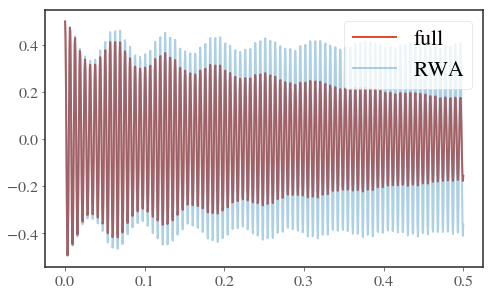

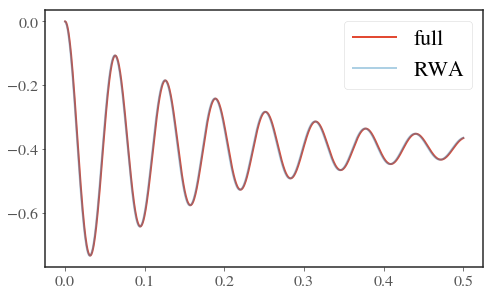

med Gamma
100.0
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=100.0 | RC-res. coupling=0.08 | TLS-RC coupling=39.63 | Gamma_RC=50.00 | alpha_ph=10.00 | N=10 |
Dynamics complete


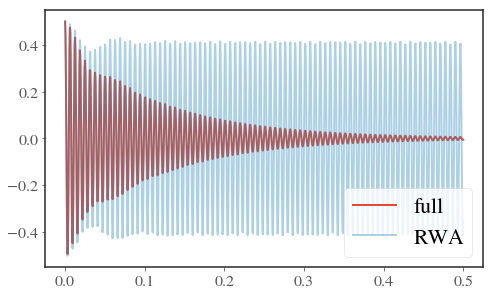

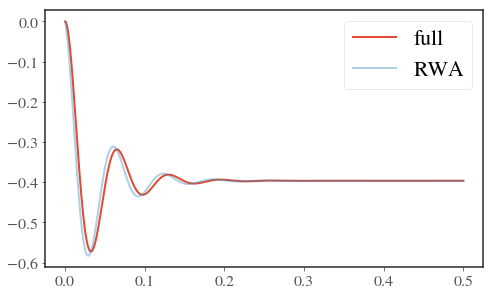

large Gamma
100.0
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=100.0 | RC-res. coupling=0.16 | TLS-RC coupling=39.63 | Gamma_RC=100.00 | alpha_ph=10.00 | N=10 |
Dynamics complete


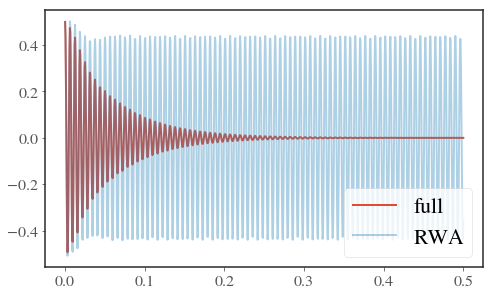

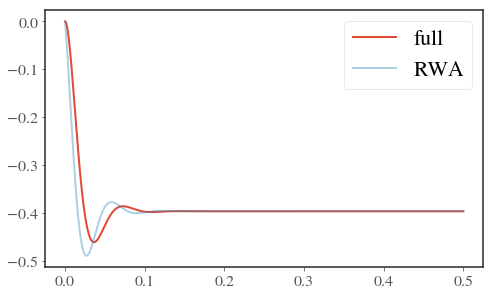

large w0 and large Gamma
8100.0
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[    0.     0.]
 [    0.  1000.]]  TLS 
T_ph=77.0
w_RC=900.0 | RC-res. coupling=0.02 | TLS-RC coupling=118.90 | Gamma_RC=100.00 | alpha_ph=10.00 | N=10 |
Dynamics complete


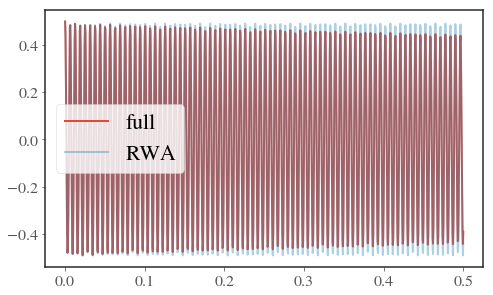

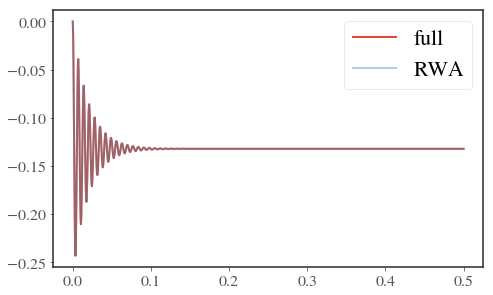

In [102]:
print "VARYING w0"
print "small w0"
plot_IBM(alpha=0.01, w0=0.05, N=10)
print "med w0"
plot_IBM(alpha=0.01, w0=0.1, N=10)
print "large w0"
plot_IBM(alpha=0.01, w0=0.9, N=6)

print "VARYING GAMMA"
print "small Gamma"
plot_IBM(alpha=0.01, w0=0.1, Gamma =0.01, N=10)
print "med Gamma"
plot_IBM(alpha=0.01, w0=0.1, Gamma =0.05, N=10)
print "large Gamma"
plot_IBM(alpha=0.01, w0=0.1, Gamma =0.1, N=10)

print "large w0 and large Gamma"
plot_IBM(alpha=0.01, w0=0.9, Gamma =0.1, N=10)

## This code shows that the RWA is not valid for the RC solution to the IBM

In [ ]:
def plot_spectra(timelist, pops, taulist, g1s, specs, freqs, g2s,
                freq_window=1000., tau_window=2., dyn_window_div = 7.):
    plt.close('all')
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(14,12))
    #f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
    #f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14,6))
    label = ['Full', 'Naive']
    ls = ['dashed', 'solid']
    for i, spec in enumerate(specs):
        g_1  = g1s[i]
        freq = freqs[i]
        ax1.plot(timelist, pops[i],
                label=label[i], linestyle=ls[i])
        ax3.plot(taulist[0:int(len(taulist)/tau_window)],
                 g_1.real[0:int(len(taulist)/tau_window)], 
                 label=label[i], linestyle=ls[i])
        #ax4.plot(taulist[0:int(len(taulist)/tau_window)],
        #         g_1.imag[0:int(len(taulist)/tau_window)], 
        #         label=label[i], linestyle=ls[i])
        ax4.plot(timelist, g2s[i], label=label[i], linestyle=ls[i])
        ax2.plot(freq, spec, label=label[i], linestyle=ls[i])
    ax1.set_xlim(0,timelist[int((len(timelist)-1)/dyn_window_div)])
    ax3.set_xlim(0,taulist[int((len(taulist)-1)/dyn_window_div)])
    #ax4.set_xlim(0,taulist[int((len(taulist)-1)/dyn_window_div)])
    ax4.set_xlim(0,timelist[int((len(timelist)-1)/dyn_window_div)])
    ax1.set_xlabel(r"Time")
    ax2.set_xlabel(r"Frequency $cm^{-1}$")
    #ax2.axvline(eps, linestyle='dashed',color='k', alpha=0.4)
    if freq_window is not None:
        ax2.set_xlim(-freq_window,freq_window)

    ax1.set_ylabel(r"Excited state population")
    ax2.set_ylabel(r"Fluorescence intensity (arb. units)")
    ax3.set_ylabel(r"$Re[g^{(1)}(\tau)]$") # coherence
    #ax4.set_ylabel(r"$Im[g_1(\tau)]$") # coherence
    ax4.set_ylabel(r"$g^{(2)}_{ss}(\tau)$") # coherence
    ax3.set_xlabel(r"$\tau$")
    #ax4.set_xlabel(r"$\tau$") # if lower right is imag part of g1
    ax4.set_xlabel(r"$\tau$")
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    plt.show()

# First order coherence function and emission spectra

In [ ]:
method = 'adams'
order = 12
reload(EM)

def RF_spectrum(H, rho_0, timelist, taulist, L, sigma_RC, 
                steps_per_tau=700.,nsteps=8000, tau_f=2., label='Full'):
    options = qt.Options(nsteps=nsteps, store_states=True)
    E_op = sigma_RC.dag()*sigma_RC
    ti = time.time()
    P = mesolve(H, rho_0, timelist, c_ops=[L], options=options).states
    pop = [((E_op*p).tr()).real for p in P]

    print "Completed initial dynamics calculations for {} in {}  seconds.".format(label, time.time()-ti)
    ti = time.time()
    Lambda_0 = sigma_RC*sum(P)
    del P
    Lambda_t = mesolve(H, Lambda_0, taulist, [L], options=options, progress_bar=None)

    g_1 = np.array([(sigma_RC.dag()*l).tr() for l in Lambda_t.states])
    g_1/=abs(g_1[0])

    spec = sp.fftpack.fft(g_1)
    dt = taulist[1]-taulist[0]
    freq = 2 * pi * np.array(sp.fftpack.fftfreq(spec.size, dt))
    spec = 2 * dt* np.real(spec)
    #freq, spec = qt.spectrum_correlation_fft(taulist, g_1) # old method
    spec-= min(spec)
    spec = spec/sum(spec)
    freq, spec = zip(*sorted(zip(freq, np.array(spec).real)))
    print "Completed correlation function calculations for {} in {} seconds.".format(label, time.time()-ti)
    return pop, g_1, spec, freq

# Second order coherence functions

In [ ]:
def coherence_2nd_order_ss(H, tlist, c_ops, sigma, rho0=None):
    """
    Calculate the correlation function <sigma_dag(0)sigma_dag(tau)sigma(tau)sigma(0)>

    (ss_gtt = steadystate general two-time)
    
    See, Gardiner, Quantum Noise, Section 5.2.1

    .. note::
        Experimental. 
    """
    ti = time.time()
    if rho0 == None:
        rho0 = steadystate(H, c_ops)
    dat = mesolve(H, sigma * rho0 * sigma.dag(), tlist, c_ops, [sigma.dag() * sigma]).expect[0]
    print "G2 took {:0.3f} seconds".format(time.time()-ti)
    return dat

In [ ]:

        

def RF_data(detuning=0., alpha=10, Rabi=1., w0=50., t_f=4., steps_per_tau=700.,
                steps_per_t=900, nsteps=8000, tau_f=2.):
    Gamma_EM =  1. #1*5.309e-3
    detuning = detuning*Gamma_EM #detuning*ev_to_inv_cm #0.01*ev_to_inv_cm
    epsilon = 1000. #1*ev_to_inv_cm
    w_laser = epsilon + detuning
    Rabi = Rabi*Gamma_EM #Rabi*ev_to_inv_cm # 0.01*ev_to_inv_cm
    T_ph = 77.
    #w0 = 50.
    wc = 52.
    Gamma =  25. #(w0**2)/100.
    alpha_ph = alpha #alpha*ev_to_inv_cm
    
    #kappa= np.sqrt(np.pi * alpha_ph * w0 / 2.)
    #shift = ((kappa**2)/w0)
    #w_laser #+= shift
    
    
    #Rabi = Gamma_EM*Rabi #Rabi*ev_to_inv_cm # 0.01*ev_to_inv_cm
    J = J_multipolar
    
    kappa= np.sqrt(np.pi * alpha_ph * w0 / 2.)
    shift = ((kappa**2)/w0)
    #w_laser += shift
    H_sub = (epsilon-w_laser)*sigma.dag()*sigma + (Rabi/2)*(sigma.dag()+sigma)
    print "Driven Hamiltonian: \n", H_sub.full()
    n_RC = Occupation(w0, T_ph)
    
    
    #print "T_ph={}".format(T_ph)
    #print "Exact solution took {} seconds.".format(time.time()-ti)
    
    if abs(alpha)>0:
        N = 7
        I = qeye(N)
        L_RC, H, A_EM, A_nrwa, Z, wRC, kappa, gamma = RC.RC_function_gen(H_sub, sigma, T_ph, Gamma, w0, alpha_ph, N, 
                                                                  silent=False, w_laser=w_laser)
        H_add = tensor(H_sub, I)
        E_op = tensor(E*E.dag(), I) # population operator
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        sigma_RC = tensor(sigma, I)
    else:
        L_RC, H, A_EM = 0, H_sub, sigma
        H_add = H_sub
        E_op = E*E.dag() # population operator
        rho_0 = initial_sys
        sigma_RC = sigma
    eps_rot = epsilon #+((kappa**2)/wRC)
    
    labels = ['Full', 'Naive']
    L_full = -EM.L_nonsecular(H, A_EM, eps_rot, Gamma_EM, T_EM, J, silent=False, w_laser=w_laser)
    
    L_add = -EM.L_nonsecular(H_add, A_EM, eps_rot, Gamma_EM, T_EM, J, silent=False, w_laser=w_laser)
    L_EM_list = [L_full, L_add]
    #final_t = end_T_mult/Gamma_EM
    #print "final t: ", final_t
    #timelist = np.linspace(0, final_t, int(T_increments*final_t))
    timelist = np.linspace(0, t_f, t_f*steps_per_t)
    taulist = np.linspace(0, tau_f, int(tau_f*steps_per_tau))
    pop_list = []
    g1_data = []
    spectrum_data = []
    freq_data = []
    g2_data = []
    for i, L_EM in enumerate(L_EM_list):
        L = L_RC + L_EM
        ss = steadystate(H, [L])
        print "Steadystate: \n", ss.ptrace(0).full()
        pop, g1, spec, freq = RF_spectrum(H, rho_0, timelist, taulist, L, sigma_RC,
                                      nsteps=nsteps, tau_f=tau_f, label=labels[i])
        g2 = coherence_2nd_order_ss(H, timelist, [L], sigma_RC, rho0=ss)
        pop_list.append(pop)
        g1_data.append(g1)
        spectrum_data.append(spec)
        freq_data.append(freq)
        norm_den = ((ss*sigma_RC.dag()*sigma_RC).tr()**2).real
        g2_data.append(g2/norm_den)
    print "All spectra calculated."
    return timelist, pop_list, taulist, g1_data, spectrum_data, freq_data, g2_data

